In [15]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JohnsonUtil import johnson_cons as ct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()
from sklearn.preprocessing import StandardScaler


'module://ipympl.backend_nbagg'

In [16]:
# signal_df 已包含 signal 和 future_return
# 3. 策略回测逻辑（多状态 signal）
# def calc_strategy_return(df):
#     df = df.copy()
#     # 买入信号：1 或 2
#     df['position'] = df['signal'].apply(lambda x: 1 if x in [1,2] else 0)
#     # 卖出信号：-1，清仓（这里暂时只考虑做多策略）
#     df['strategy_return'] = df['position'] * df['future_return']
#     # 累积收益
#     df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()
#     return df

# # signal_df = calc_strategy_return(signal_df)

def calc_strategy_return(signal_df, signal_col='signal', price_col1='lastp1d', price_col2='lastp2d'):
    """
    根据多状态信号计算策略收益和累计收益
    只在 EVAL_STATE=1(启动) 或 2(主升) 建仓，其余状态不建仓
    
    参数：
        signal_df : pd.DataFrame
            包含 signal, EVAL_STATE, lastp1d, lastp2d 等列
        signal_col : str
            信号列名
        price_col1 : str
            当日价格列（用于计算未来收益）
        price_col2 : str
            前一日价格列
    
    返回：
        pd.DataFrame : 原 DataFrame 增加如下列
            future_return, filtered_signal, strategy_return,
            cumulative_strategy_return, cumulative_market_return
    """
    df = signal_df.copy()
    
    # 1日未来收益
    df['future_return'] = df[price_col1] / df[price_col2] - 1

    # 策略信号过滤，只在启动/主升建仓
    df['filtered_signal'] = df.apply(
        lambda row: row[signal_col] if row.get('EVAL_STATE', 0) in [1, 2] else 0, axis=1
    )

    # 策略收益
    df['strategy_return'] = df['filtered_signal'] * df['future_return']

    # 累计收益
    df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()
    df['cumulative_market_return'] = (1 + df['future_return']).cumprod()

    return df

def calc_eval_state(df):
    """
    根据价格和指标计算 EVAL_STATE
    9 = 空头, 1 = 启动, 2 = 主升, 3 = 回撤, 0 = 无效数据
    """
    def eval_row(row):
        price = row['lastp1d']
        upper = row.get('upper1', 0)
        ma = row.get('ma5', 0)  # 可以改成守护 MA 支撑线，例如 ma5 或 ma20
        if price <= 0:
            return 0
        elif price < ma:
            return 9  # 空头
        elif price > upper and row.get('vol', 0) > 0:  # 放量突破 upper
            return 1  # 启动
        elif price >= upper:
            return 2  # 主升
        else:
            return 3  # 回撤

    df['EVAL_STATE'] = df.apply(eval_row, axis=1)
    return df


# 特征标准化/归一化

# 特征筛选或降维

In [17]:
def generate_df_vect_daily_features_safe(df, lastdays=5):
    """多股票，生成每只股票最近 lastdays 的特征字典列表"""
    features_list = []
    cols_map = {
        'open': 'lasto',
        'high': 'lasth',
        'low': 'lastl',
        'close': 'lastp',
        'vol': 'lastv',
        'upper': 'upper',
        'ma5d': 'ma5',
        'ma20d': 'ma20',
        'ma60d': 'ma60',
        'perlastp': 'perc',
        'perd': 'per'
    }
    
    for code, df_stock in df.groupby(level=0):
        feat = {'code': str(code)}
        df_stock = df_stock.sort_index(level=1)  # 按日期升序
        
        for da in range(1, lastdays+1):
            for col, prefix in cols_map.items():
                # if col in df_stock.columns and len(df_stock) >= da:
                #     feat[f'{prefix}{da}d'] = df_stock[col].iloc[-da]
                # else:
                #     feat[f'{prefix}{da}d'] = 0
                if col in df_stock.columns and len(df_stock) >= da:
                    # upper 列不加 d 后缀
                    if col == 'upper':
                        feat[f'{prefix}{da}'] = df_stock[col].iloc[-da]
                    else:
                        feat[f'{prefix}{da}d'] = df_stock[col].iloc[-da]
                else:
                    if col == 'upper':
                        feat[f'{prefix}{da}'] = 0
                    else:
                        feat[f'{prefix}{da}d'] = 0
            
            # eval / signal
            for suffix in ['eval', 'signal']:
                colname = f'{suffix}{da}d'
                if colname in df_stock.columns and len(df_stock) >= da:
                    feat[colname] = df_stock[colname].iloc[-da]
                else:
                    feat[colname] = 0
        features_list.append(feat)
    
    return pd.DataFrame(features_list)

In [18]:
code_l=['920274','300342','300696', '603091', '605167']

resample='d'

# df = tdd.get_tdx_exp_all_LastDF_DL(code_l, dt=ct.Resample_LABELS_Days[resample], resample=resample)

df, tdxdata = tdd.get_append_lastp_to_df()
# df_feat = tdd.generate_df_vect_daily_features(df,lastdays=cct.compute_lastdays)
# 排除非数值列（code 和 date）
# 假设 df_feat 中有 trade_signal

# # 假设 signal_df 的 index 是 MultiIndex (code, date)，或者按日期升序
# df = df.sort_index(level=1)  # 按日期升序

# # 计算1日未来收益
# # df['future_return'] = df.groupby(level=0)['close'].shift(-1) / df['close'] - 1
# # 1日收益 = (今天 - 昨天) / 昨天
# df['future_return'] = df['lastp1d'] / df['lastp2d'] - 1



initdx :0 b1>:5446 it:0.5 tdx_last_df:1.19 

In [19]:
df['signal1d'][-2:],df['EVAL_STATE'][-2:]

(code
 600331    5.0
 002132    5.0
 Name: signal1d, dtype: float64,
 code
 600331    1.0
 002132    9.0
 Name: EVAL_STATE, dtype: float64)

In [20]:
target_cols = ['trade_signal', 'EVAL_STATE']  # 如果有多个目标列
df_target = df[target_cols]

In [21]:
# -*- coding: utf-8 -*-
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ============================================
# 1. 设定参数
# ============================================
lastdays = 9  # 提取最近 N 天特征

# ============================================
# 2. 获取最近交易日数据
# 假设 df 的 index 是 MultiIndex: (code, date)
# ============================================
# latest_date = df.index.get_level_values(1).max()
# print("最新交易日:", latest_date)

# # 只保留最新交易日及历史 lastdays-1 日
df_recent = df.groupby(level=0).apply(
    lambda x: x.sort_index(level=1).tail(lastdays)
).reset_index(level=0, drop=False)  # 保留 code

# ============================================
# 3. 生成矢量化特征
# ============================================

# df_feat = generate_df_vect_daily_features_safe(df_recent, lastdays=lastdays)

# # 过滤掉 upper <= 0 的行
# df_feat = df_feat.query('upper1d > 0')

# # ============================================
# # 4. 特征标准化
# # ============================================
# scaler = StandardScaler()

# # signal 和 eval 不做标准化
# exclude_cols = ['code'] + [f'{s}{d}d' for d in range(1,lastdays+1) for s in ['eval','signal']]
# feat_cols = [c for c in df_feat.columns if c not in exclude_cols]

# df_feat_scaled = df_feat.copy()
# df_feat_scaled[feat_cols] = scaler.fit_transform(df_feat[feat_cols])

# # ============================================
# # 5. 输出结果
# # ============================================
# print(df_feat_scaled.head())

# # df_feat_scaled 可以直接作为模型输入


# 假设 df_feat 是 generate_df_vect_daily_features 返回的 DataFrame
df_feat = pd.DataFrame(generate_df_vect_daily_features_safe(df, lastdays=cct.compute_lastdays))
df_feat = df_feat.query('upper1 > 0')

In [22]:


# 标准化特征列（不包括 code 和目标列）
feat_cols = [c for c in df_feat.columns if c not in ['code'] + target_cols]
df_feat_scaled = df_feat.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_feat_scaled[feat_cols] = scaler.fit_transform(df_feat[feat_cols])

# 将目标列重新合并
# 重置索引，让 code 变成列
df_target_reset = df_target.reset_index()
df_feat_scaled_reset = df_feat_scaled.reset_index(drop=True)  # 原来的索引丢掉

# 将目标列合并
df_feat_scaled_reset[target_cols] = df_target_reset[target_cols]


In [23]:
target_cols,df_target,df_feat_scaled_reset

(['trade_signal', 'EVAL_STATE'],
         trade_signal  EVAL_STATE
 code                            
 920978           5.0         9.0
 920149           5.0         9.0
 920946           5.0         9.0
 920124           5.0         9.0
 920132           5.0         9.0
 ...              ...         ...
 603703           5.0         9.0
 601188           5.0         9.0
 002555           5.0         2.0
 600331           5.0         1.0
 002132           5.0         9.0
 
 [5445 rows x 2 columns],
         code   lasto1d   lasth1d   lastl1d   lastp1d  lastv1d    upper1  \
 0     000001 -0.340530 -0.345137 -0.336712 -0.341044      0.0 -0.340653   
 1     000002 -0.489819 -0.491515 -0.488038 -0.490300      0.0 -0.471535   
 2     000004 -0.354822 -0.358091 -0.354594 -0.355375      0.0 -0.328768   
 3     000006 -0.374609 -0.371909 -0.370911 -0.370807      0.0 -0.365115   
 4     000007 -0.340530 -0.342115 -0.342300 -0.344351      0.0 -0.325692   
 ...      ...       ...       ...       .

In [24]:
df_feat_scaled_reset[target_cols]

,trade_signal,EVAL_STATE
0,5.0,9.0
1,5.0,9.0
2,5.0,9.0
3,5.0,9.0
4,5.0,9.0
...,...,...
5440,5.0,9.0
5441,5.0,9.0
5442,5.0,2.0
5443,5.0,1.0


## 特征与标签准备（Supervised Learning）

In [25]:
# 假设 trade_signal 是目标
X = df_feat_scaled_reset.drop(columns=['code','trade_signal','EVAL_STATE'], errors='ignore')
y = df_feat_scaled_reset['trade_signal']  # 或者 'EVAL_STATE'

### 然后可以直接拆训练集/测试集：

In [26]:
from sklearn.model_selection import train_test_split

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 查看训练集和测试集的大小
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# 查看前几行数据
print(X_train.head())
print(y_train.head())


X_train: (4356, 65)
X_test : (1089, 65)
y_train: (4356,)
y_test : (1089,)
       lasto1d   lasth1d   lastl1d   lastp1d  lastv1d    upper1     ma51d  \
1660 -0.395936 -0.400191 -0.395722 -0.399248      0.0 -0.389582 -0.394237   
1573 -0.441229 -0.444666 -0.442215 -0.444223      0.0 -0.433061 -0.438409   
446  -0.434633 -0.437325 -0.432604 -0.434963      0.0 -0.425059 -0.430280   
2950 -0.471790 -0.474028 -0.471944 -0.473104      0.0 -0.458099 -0.466778   
2696  0.656563  0.634603  0.644113  0.634739      0.0  0.569925  0.637568   

        ma201d    ma601d    perc1d  ...  lastp5d  lastv5d  upper5  ma55d  \
1660 -0.390743 -0.298789 -0.446520  ...      0.0      0.0     0.0    0.0   
1573 -0.444003 -0.358655 -1.388536  ...      0.0      0.0     0.0    0.0   
446  -0.427034 -0.329225  0.331667  ...      0.0      0.0     0.0    0.0   
2950 -0.474147 -0.385526 -1.306621  ...      0.0      0.0     0.0    0.0   
2696  0.685194  0.772913 -0.200777  ...      0.0      0.0     0.0    0.0   

      

## 随机森林

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=8, 
    random_state=42
)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [28]:
y_pred = clf.predict(X_test)


In [29]:
y_proba = clf.predict_proba(X_test)[:, 1]  # 对于二分类，取类别1概率


### 模型评估

#### 分类

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9393939393939394
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        13
         1.0       0.00      0.00      0.00        21
         2.0       0.00      0.00      0.00        32
         5.0       0.94      1.00      0.97      1023

    accuracy                           0.94      1089
   macro avg       0.23      0.25      0.24      1089
weighted avg       0.88      0.94      0.91      1089

[[   0    0    0   13]
 [   0    0    0   21]
 [   0    0    0   32]
 [   0    0    0 1023]]


#### 回归

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))


MSE: 1.002754820936639
R2 : -0.059293227296049356


#### 特征重要性分析

In [32]:
import pandas as pd
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).head(5)


lastl1d    0.108771
upper1     0.104996
lastp1d    0.102490
lasth1d    0.101720
ma51d      0.101058
dtype: float64

#### 模型保存

In [33]:
import joblib
# joblib.dump(clf, "rf_model.pkl")

In [35]:
# df.signal9d[-2:]

#### 后续操作


##### 调整模型超参数 (max_depth, n_estimators, learning_rate 等) 做 网格搜索或贝叶斯优化

结合股票特征做 回测策略

可以使用 predict_proba 输出信号强度，选择 top N 买入股票

### 随机森林 做示例可以替换成 XGBoost 或其他模型

RandomForestClassifier(max_depth=6, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)

=== 分类报告 ===
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        13
         1.0       0.00      0.00      0.00        21
         2.0       0.00      0.00      0.00        32
         5.0       0.94      1.00      0.97      1023

    accuracy                           0.94      1089
   macro avg       0.23      0.25      0.24      1089
weighted avg       0.88      0.94      0.91      1089

=== 混淆矩阵 ===
[[   0    0    0   13]
 [   0    0    0   21]
 [   0    0    0   32]
 [   0    0    0 1023]]


upper1      0.106821
lasto1d     0.106129
lastp1d     0.102119
ma201d      0.101674
ma51d       0.098021
perc1d      0.097002
lastl1d     0.096997
lasth1d     0.092437
ma601d      0.090232
per1d       0.076176
eval1d      0.020671
signal1d    0.011722
signal4d    0.000000
lastl4d     0.000000
lastp4d     0.000000
lastv4d     0.000000
lasth4d     0.000000
upper4      0.000000
ma54d       0.000000
ma204d      0.000000
dtype: float64

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Top 20 Feature Importances')

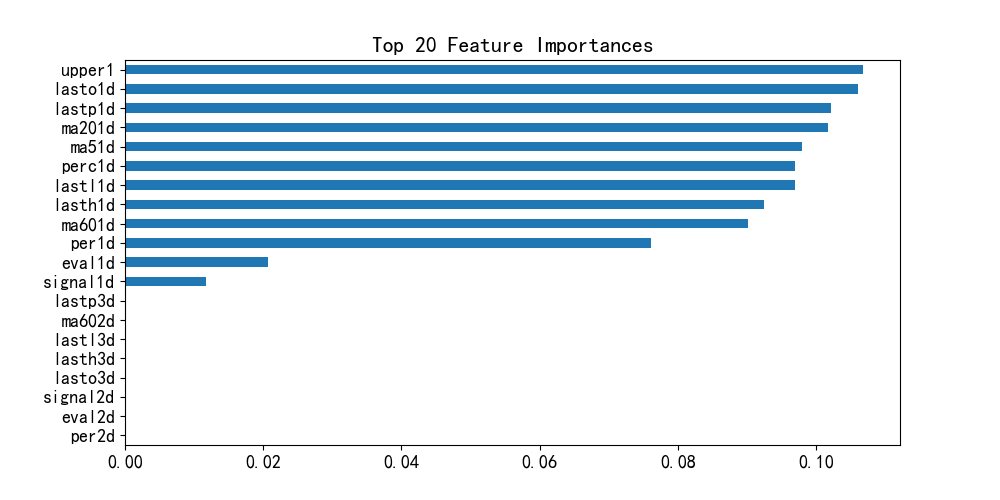

In [36]:
# -------------------------------
# Step 0: 导入必要库
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: 准备数据
# 假设你已有 X, y
# X: 特征表，y: 目标信号（9d）
# -------------------------------
# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# Step 2: 训练模型
# -------------------------------
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# -------------------------------
# Step 3: 模型评估
# -------------------------------
y_pred = clf.predict(X_test)
print("=== 分类报告 ===")
print(classification_report(y_test, y_pred))

print("=== 混淆矩阵 ===")
print(confusion_matrix(y_test, y_pred))

# -------------------------------
# Step 4: 特征重要性
# -------------------------------
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).head(20)

# 可视化
plt.figure(figsize=(10,5))
feat_importances.sort_values(ascending=True).tail(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()



In [37]:
full_data = df.copy()
full_data['EVAL_STATE']

code
920978    9.0
920149    9.0
920946    9.0
920124    9.0
920132    9.0
         ... 
603703    9.0
601188    9.0
002555    2.0
600331    1.0
002132    9.0
Name: EVAL_STATE, Length: 5445, dtype: float64

In [38]:
import pandas as pd

# -------------------------------
# 1. 生成 full_X
# -------------------------------
# 假设 full_data 是最近全市场的原始特征 DataFrame
# 需要保证列名和训练集 X_train 一致
full_X = full_data[X_train.columns].copy()

# -------------------------------
# 2. 模型预测
# -------------------------------
signals = clf.predict(full_X)  # 分类信号
probabilities = clf.predict_proba(full_X)[:, 1]  # 预测概率，二分类时取第1列

# -------------------------------
# 3. 合并结果
# -------------------------------
signal_df = full_X.copy()
signal_df['signal'] = signals
signal_df['prob'] = probabilities

# 如果你有股票代码列，可以添加到 signal_df，例如：
# signal_df['code'] = full_data['code']
# signal_df['name'] = full_data['name']

# -------------------------------
# 4. 排序 TopN
# -------------------------------
topN = 50  # 取概率最高的 50 只股票
top_stocks = signal_df.sort_values('prob', ascending=False).head(topN)

# -------------------------------
# 5. 查看结果
# -------------------------------
print(top_stocks[['signal', 'prob']].head(10))


        signal      prob
code                    
600527     5.0  0.072059
002219     5.0  0.068247
000709     5.0  0.066942
000488     5.0  0.065817
001227     5.0  0.065699
600231     5.0  0.062738
600010     5.0  0.062107
600169     5.0  0.059639
000552     5.0  0.058976
300027     5.0  0.058548


In [39]:
# Step 5: 全市场信号预测
signals = clf.predict(full_X)
probabilities = clf.predict_proba(full_X)[:, 1]

signal_df = full_X.copy()
signal_df['signal'] = signals
signal_df['prob'] = probabilities
signal_df['EVAL_STATE'] = full_data['EVAL_STATE']  # 假设全市场数据里已经有 EVAL_STATE 列

# Step 6: 策略回测
signal_df = calc_strategy_return(signal_df)

# 查看前几行
print(signal_df[['signal', 'EVAL_STATE', 'future_return', 'filtered_signal', 'strategy_return', 'cumulative_strategy_return']].head())

# 按概率选出潜力股
top_signal = signal_df.sort_values('prob', ascending=False)
print(top_signal[['signal', 'prob', 'EVAL_STATE']][-10:])


        signal  EVAL_STATE  future_return  filtered_signal  strategy_return  \
code                                                                          
920978     5.0         9.0      -0.020000              0.0             -0.0   
920149     5.0         9.0      -0.006711              0.0             -0.0   
920946     5.0         9.0      -0.006464              0.0             -0.0   
920124     5.0         9.0       0.015516              0.0              0.0   
920132     5.0         9.0      -0.008197              0.0             -0.0   

        cumulative_strategy_return  
code                                
920978                         1.0  
920149                         1.0  
920946                         1.0  
920124                         1.0  
920132                         1.0  
        signal      prob  EVAL_STATE
code                                
301330     5.0  0.009956         9.0
002331     5.0  0.009956         9.0
002006     5.0  0.009956         9.0
68

In [40]:
def run_full_signal_backtest(clf, full_X, top_n=50):
    """
    1. 使用模型预测信号
    2. 基于 EVAL_STATE 筛选有效建仓信号
    3. 计算未来 1 日收益
    4. 计算策略收益和累计收益
    5. 返回 top N 潜力股
    
    full_X: 最近全市场特征 DataFrame，必须包含 lastp1d/lastp2d, EVAL_STATE, signal列
    clf: 训练好的分类器
    """
    import pandas as pd

    df = full_X.copy()

    # 预测信号
    df['signal_model'] = clf.predict(df[full_X.columns.drop(['EVAL_STATE', 'signal1d','signal9d','eval9d'], errors='ignore')])
    if hasattr(clf, "predict_proba"):
        df['prob'] = clf.predict_proba(df[full_X.columns.drop(['EVAL_STATE', 'signal1d','signal9d','eval9d'], errors='ignore')])[:,1]
    else:
        df['prob'] = 0.5  # 没有概率输出时

    # 只在 EVAL_STATE 为启动/主升状态建仓
    df['filtered_signal'] = df['signal_model']
    df.loc[~df['EVAL_STATE'].isin([1,2]), 'filtered_signal'] = 0

    # 未来1日收益
    df['future_return'] = df['lastp1d'] / df['lastp2d'] - 1

    # 策略收益
    df['strategy_return'] = df['filtered_signal'] * df['future_return']
    df['cumulative_strategy_return'] = (1 + df['strategy_return']).cumprod()
    df['cumulative_market_return'] = (1 + df['future_return']).cumprod()

    # top N 潜力股
    top_signal = df.sort_values('prob', ascending=False).head(top_n)

    return df, top_signal

# # 使用示例
# signal_df, top_signal = run_full_signal_backtest(clf, full_X, top_n=50)
# print(top_signal[['filtered_signal','prob','EVAL_STATE']])


In [41]:
import numpy as np
import pandas as pd

def backtest_signals_clean(full_X, df_stock_data, clf, top_n=50, log_safe=True):
    """
    全市场信号预测 + 回测（安全版，filtered_signal 最大为1）
    """
    signal_df = full_X.copy()

    # 1. 模型预测
    signal_df['signal'] = clf.predict(full_X)
    signal_df['prob'] = clf.predict_proba(full_X)[:, 1]

    # 2. 加入 EVAL_STATE
    signal_df['EVAL_STATE'] = df_stock_data['EVAL_STATE']

    # 3. 计算1日收益
    signal_df['future_return'] = df_stock_data['lastp1d'] / df_stock_data['lastp2d'] - 1

    # 4. 策略信号过滤（只在启动/主升建仓，权重限制为1）
    signal_df['filtered_signal'] = signal_df.apply(
        lambda r: 1 if (r['signal'] > 0 and r['EVAL_STATE'] in [1, 2]) else 0,
        axis=1
    )

    # 5. 策略收益
    signal_df['strategy_return'] = signal_df['filtered_signal'] * signal_df['future_return']

    # 6. 安全累积收益
    safe_strategy_return = np.clip(signal_df['strategy_return'], -0.99, 0.99)
    if log_safe:
        signal_df['cumulative_strategy_return'] = np.expm1(np.log1p(safe_strategy_return).cumsum())
    else:
        signal_df['cumulative_strategy_return'] = (1 + safe_strategy_return).cumprod()

    # 市场累计收益
    safe_market_return = np.clip(signal_df['future_return'], -0.99, 0.99)
    signal_df['cumulative_market_return'] = (1 + safe_market_return).cumprod()

    # 7. 输出潜力股
    # top_signal = signal_df.sort_values('prob', ascending=False).head(top_n)
    top_signal = signal_df.sort_values('prob', ascending=False)
    return signal_df, top_signal


In [42]:
signal_df, top_signal = backtest_signals_clean(full_X, df, clf, top_n=50)

# 查看前50潜力股
print(top_signal[['signal','prob','EVAL_STATE','filtered_signal','future_return','strategy_return','cumulative_strategy_return']].head())

# 查看前几行回测结果
print(signal_df[['signal','future_return','strategy_return','cumulative_strategy_return']].head())


        signal      prob  EVAL_STATE  filtered_signal  future_return  \
code                                                                   
600527     5.0  0.072059         9.0                0       0.000000   
002219     5.0  0.068247         9.0                0       0.004566   
000709     5.0  0.066942         9.0                0       0.004255   
000488     5.0  0.065817         3.0                0      -0.008969   
001227     5.0  0.065699         9.0                0       0.000000   

        strategy_return  cumulative_strategy_return  
code                                                 
600527              0.0                  278.996328  
002219              0.0                24672.314215  
000709              0.0                    2.707447  
000488             -0.0                   39.172948  
001227              0.0                    2.707447  
        signal  future_return  strategy_return  cumulative_strategy_return
code                                      

In [43]:
def show_tdx_data_all(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

In [44]:
def show_tdx_data(df, codelist=None, market_value='3', col=None):

    columns_ = [
        "name", "category", "close", "percent",'volra', 'topR', "lastp1d", "ma5dcum",
        "ma20d", "fib", "fibl", "ra", "ral", "df2", "per1d", "hmax", "lmin",
        "per%sd" % (market_value),
        "perc%sd" % (market_value)]
    if isinstance(df, pd.Series):
        columns_ = [co for co in columns_ if co in df.index]
    else:
        columns_ = [co for co in columns_ if co in df.columns]
    if col is not None:
        columns_.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            # print("Count:1")
            temp = df.loc[columns_]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, columns_]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], columns_]
    return temp


In [45]:
top_signal.shape

(5445, 73)

In [46]:
top50 =  top_signal.sort_values('prob', ascending=False).head(50)
show_tdx_data(df.loc[top50.index][-10:])


Count:10 238


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
600582,天地科技,高股息精选;煤炭概念;中俄贸易概念;国企改革;央企国企改革;人工智能;机器人概念;华为概念;...,5.79,0.17,0.0,5.79,5.8,5.863768,0,3,0,0,0,0.2,6.19,5.66,0.9,7.0
600725,云维股份,化肥;煤化工概念;煤炭概念;国企改革;西部大开发;超超临界发电;股权转让(并购重组),4.10,0.24,0.0,4.10,4.1,3.900710,0,2,3,7,0,0.2,4.27,3.50,-3.3,-19.0
600238,*ST椰岛,ST板块;免税店;海南自贸区;跨境电商;白酒概念;养老概念;国企改革;,6.52,0.15,0.0,6.52,6.6,6.588802,0,3,1,2,0,0.2,6.98,6.33,-2.5,-27.0
300168,万达信息,DRG/DIP;家庭医生;智慧政务;财税数字化;数据要素;在线教育;华为鲲鹏;虚拟数字人;A...,6.43,0.16,0.0,6.43,6.5,6.636157,0,2,1,0,0,0.2,7.25,6.20,0.9,10.0
600643,爱建集团,信托概念;互联网金融;参股券商;物业管理;沪股通;,5.55,0.18,0.0,5.55,5.4,5.416641,0,4,2,1,0,0.2,5.82,5.09,2.1,4.0
002726,龙大美食,猪肉;预制菜;;深股通,4.22,0.24,0.0,4.22,4.2,4.392862,0,1,0,0,0,0.2,4.97,4.08,0.0,-3.0
300006,莱美药业,仿制药一致性评价;辅助生殖;幽门螺杆菌概念;肝炎概念;细胞免疫治疗;创新药;医药电商;眼科医...,5.26,0.19,0.0,5.26,5.0,5.006950,0,4,1,8,0,0.2,5.45,4.45,-2.1,-6.0
600469,风神股份,国企改革;央企国企改革;新能源汽车;,6.90,0.15,0.0,6.90,6.8,6.822204,0,5,0,5,0,0.1,7.12,6.55,0.1,-12.0
000793,ST华闻,ST板块;农业种植;旅游概念;参股券商;化债概念(AMC概念);网红经济;文化传媒概念;乡村...,2.84,0.00,0.0,2.84,2.9,2.894369,0,3,0,0,0,0.0,3.09,2.71,-1.0,-14.0


In [47]:
# plt.figure(figsize=(10,5))
# plt.plot(cumulative_return, label='策略累积收益')
# plt.plot(signal_df['return'].cumsum(), label='基准累积收益')
# plt.legend()
# plt.show()

# -------------------------------
# Step 7: 进一步优化
# - 调整特征窗口
# - 调整目标天数（5d, 7d, 9d）
# - 调参 n_estimators, max_depth, min_samples_leaf
# - 特征选择：剔除重要性为0的列
# - 回测策略：加资金管理、止损止盈
# -------------------------------


In [48]:
print(df.columns.tolist())

['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell', 'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v', 'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v', 'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'nlow', 'nhigh', 'nclose', 'nstd', 'lastbuy', 'timel', 'percent', 'ratio', 'dff', 'couts', 'kind', 'prev_p', 'lopen', 'lhigh', 'llow', 'lastp', 'lvol', 'lamount', 'lower', 'upper', 'ene', 'bandwidth', 'bollpect', 'boll_sq', 'boll_signal', 'macddif', 'macddea', 'macd', 'macdlast1', 'macdlast2', 'macdlast3', 'macdlast4', 'macdlast5', 'macdlast6', 'rsi', 'kdj_k', 'kdj_d', 'kdj_j', 'EMA10', 'EMA20', 'SWL', 'CAPITAL', 'SWS', 'resist_next', 'support_next', 'break_next', 'reverse_next', 'resist_today', 'support_today', 'score', 'maxp', 'fib', 'maxpcout', 'ma5d', 'ma10d', 'ma20d', 'ma60d', 'truer', 'op', 'op_ldate', 'topU', 'eneU', 'bullbreak', 'bull_f', 'bull_s', 'entry', 'sl', 'tp', 'alert', 'status', 'has_first', 'ob

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_daily_signals(df, top_n=50, plot=False):
    """
    今天的策略信号分析
    
    参数:
    - df: 包含今天信号的数据，必须有 ['signal','prob','EVAL_STATE','filtered_signal','future_return','strategy_return']
    - top_n: 潜力股数量
    - plot: 是否绘制概率分布图
    
    返回:
    - top_signal: 按概率排序的前 top_n 潜力股
    - stats: 策略收益统计信息
    """
    df = df.copy()
    
    # 筛选今天的潜力股
    # top_signal = df[df['filtered_signal'] > 0].sort_values('prob', ascending=False).head(top_n)
    top_signal = df[df['filtered_signal'] > 0].sort_values('prob', ascending=False)
    # 策略收益统计
    stats = df['strategy_return'].describe()
    stats_dict = stats.to_dict()
    stats_dict['positive_ratio'] = (df['strategy_return'] > 0).mean()
    stats_dict['signal_coverage'] = (df['filtered_signal'] > 0).mean()
    
    if plot:
        plt.figure(figsize=(12,4))
        plt.scatter(df.index, df['prob'], c=df['filtered_signal'], cmap='coolwarm', s=50)
        plt.colorbar(label='filtered_signal')
        plt.xlabel('Stock Code')
        plt.ylabel('Signal Probability')
        plt.title('Today Signal Probabilities & Filtered Signals')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    return top_signal, stats_dict


In [50]:
top_signal, stats = analyze_daily_signals(top_signal)
print(stats)
print(top_signal[['signal','prob','EVAL_STATE','future_return','strategy_return']])


{'count': 5445.0, 'mean': 0.002709842464572198, 'std': 0.017344238716739287, 'min': -0.10000000000000009, '25%': 0.0, '50%': 0.0, '75%': 0.0, 'max': 0.20093215950284837, 'positive_ratio': 0.10449954086317723, 'signal_coverage': 0.1775941230486685}
        signal      prob  EVAL_STATE  future_return  strategy_return
code                                                                
920021     5.0  0.040788         1.0      -0.014472        -0.014472
920491     5.0  0.038939         1.0      -0.009563        -0.009563
002004     5.0  0.038819         1.0       0.002053         0.002053
002501     5.0  0.038262         2.0       0.024291         0.024291
600725     5.0  0.038209         2.0       0.002445         0.002445
...        ...       ...         ...            ...              ...
002179     5.0  0.010929         1.0      -0.002867        -0.002867
688370     5.0  0.010929         1.0      -0.003215        -0.003215
601882     5.0  0.010857         1.0      -0.008197        -0.

In [51]:
top_signal.columns

Index(['lasto1d', 'lasth1d', 'lastl1d', 'lastp1d', 'lastv1d', 'upper1',
       'ma51d', 'ma201d', 'ma601d', 'perc1d', 'per1d', 'eval1d', 'signal1d',
       'lasto2d', 'lasth2d', 'lastl2d', 'lastp2d', 'lastv2d', 'upper2',
       'ma52d', 'ma202d', 'ma602d', 'perc2d', 'per2d', 'eval2d', 'signal2d',
       'lasto3d', 'lasth3d', 'lastl3d', 'lastp3d', 'lastv3d', 'upper3',
       'ma53d', 'ma203d', 'ma603d', 'perc3d', 'per3d', 'eval3d', 'signal3d',
       'lasto4d', 'lasth4d', 'lastl4d', 'lastp4d', 'lastv4d', 'upper4',
       'ma54d', 'ma204d', 'ma604d', 'perc4d', 'per4d', 'eval4d', 'signal4d',
       'lasto5d', 'lasth5d', 'lastl5d', 'lastp5d', 'lastv5d', 'upper5',
       'ma55d', 'ma205d', 'ma605d', 'perc5d', 'per5d', 'eval5d', 'signal5d',
       'signal', 'prob', 'EVAL_STATE', 'future_return', 'filtered_signal',
       'strategy_return', 'cumulative_strategy_return',
       'cumulative_market_return'],
      dtype='object')

In [52]:
# print(df.columns.tolist())

In [53]:
import numpy as np
import pandas as pd

def score_strong_pullback_ma5(df, min_score=60):
    """
    强势股 MA5 回调打分模型

    Parameters
    ----------
    df : DataFrame
        必须包含 ma5d, ma10d, ma20d, ma60d,
        lastp1d, lastp2d, lastp3d,
        lastv1d, lastv2d, close
    min_score : int
        最低保留分数，默认 60

    Returns
    -------
    DataFrame
        增加以下字段：
        trend_score, pullback_score, volume_score, strong_score
        并按 strong_score 倒序
    """

    _df = df.copy()

    # ================= Trend Score =================
    _df["trend_score"] = 0

    _df.loc[_df.ma5d > _df.ma10d, "trend_score"] += 10
    _df.loc[_df.ma10d > _df.ma20d, "trend_score"] += 10
    _df.loc[_df.ma20d > _df.ma60d, "trend_score"] += 10

    _df.loc[
        (_df.lastp1d > _df.lastp2d) & (_df.lastp2d > _df.lastp3d),
        "trend_score"
    ] += 10

    # ================= Pullback Score =================
    _df["pullback_score"] = 0
    pullback_ratio = (_df.close - _df.ma5d).abs() / _df.ma5d

    _df.loc[pullback_ratio <= 0.005, "pullback_score"] += 20
    _df.loc[(pullback_ratio > 0.005) & (pullback_ratio <= 0.01), "pullback_score"] += 15
    _df.loc[(pullback_ratio > 0.01) & (pullback_ratio <= 0.02), "pullback_score"] += 10

    _df.loc[_df.close > _df.ma5d, "pullback_score"] += 10
    _df.loc[_df.close > _df.ma10d, "pullback_score"] += 10

    # ================= Volume Score =================
    _df["volume_score"] = 0
    vol_ratio = _df.lastv1d / _df.lastv2d.replace(0, np.nan)

    _df.loc[vol_ratio >= 1.0, "volume_score"] += 20
    _df.loc[(vol_ratio >= 0.7) & (vol_ratio < 1.0), "volume_score"] += 15
    _df.loc[(vol_ratio >= 0.5) & (vol_ratio < 0.7), "volume_score"] += 10

    # ================= Strong Score =================
    _df["strong_score"] = (
        _df.trend_score +
        _df.pullback_score +
        _df.volume_score
    )

    # ================= Filter & Sort =================
    _df = _df[_df.strong_score >= min_score]
    _df = _df.sort_values("strong_score", ascending=False)

    return _df


In [54]:
df_strong = score_strong_pullback_ma5(df)
df_strong.shape
df_strong[
    ["name", "close", "ma5d", "ma10d",
     "trend_score", "pullback_score",
     "volume_score", "strong_score"]
].head(20)

(3251, 242)

,name,close,ma5d,ma10d,trend_score,pullback_score,volume_score,strong_score
code,,,,,,,,
601816,京沪高铁,5.22,5.195011,5.180956,40,40,20,100
600725,云维股份,4.10,4.096010,4.033131,40,40,20,100
002831,裕同科技,29.09,28.957554,28.933780,40,40,20,100
603233,大参林,18.12,18.040675,17.952789,40,40,20,100
301507,民生健康,15.73,15.663028,15.570342,40,40,20,100
603730,岱美股份,8.11,8.070813,8.054786,40,40,15,95
301189,奥尼电子,39.48,39.276782,39.233303,40,35,20,95
601226,华电科工,8.05,7.982854,7.943463,40,35,20,95
688600,皖仪科技,24.09,23.901421,23.707735,40,35,20,95


In [55]:
strong_pullback_ma5 = df.query(
    "ma5d > ma10d > ma20d > ma60d "
    "and lastp1d > lastp2d > lastp3d "
    "and lasth1d > lasth2d > lasth3d "
    "and lastl1d > lastl2d > lastl3d "
    "and close <= ma5d * 1.01 "
    "and close >= ma5d * 0.97 "
    "and close > ma10d "
    "and lastv1d >= lastv2d * 0.7"
).copy()


In [56]:
def is_upper_attack(df):
    # mask = (
    # (df.close >= df.upper * 0.98) &
    # (df.bandwidth > df.bandwidth.rolling(10).mean()) &
    # (df.ma5d > df.ma10d) &
    # (df.ma10d > df.ma20d)
    #     )
    bw_ma10 = df.bandwidth.rolling(10).mean()

    mask = (
        (df.close >= df.upper * 0.98) &
        (df.bandwidth > bw_ma10) &
        (df.bandwidth.shift(1) <= bw_ma10.shift(1)) &  # ← 关键
        (df.ma5d > df.ma10d) &
        (df.ma10d > df.ma20d)
    )
    upper_attack = df[mask]

    return (upper_attack)


In [57]:
def is_upper_attack_first_touch(df):
    mask = (
        (df.close >= df.upper * 0.98) &
        (df.close.shift(1) < df.upper.shift(1) * 0.95) &  # 昨天没在上轨
        (df.close.shift(1) > df.ene) &                   # 从中轨上来
        (df.bandwidth > df.bandwidth.shift(1))
    )
    return df[mask]

In [58]:
def ma60_pullback_by_category_base(df, category_name="商业航天", max_pct_chg=8):
    """
    筛选指定板块的 MA60 突破回踩潜在动能股

    参数：
        df : pd.DataFrame
            股票数据，必须包含以下列：
            ['close', 'ma5d', 'ma60d', 'lastv1d', 'lastv2d', 'lastp1d', 'category']
        category_name : str
            板块名关键字，例如 "商业航天"
        max_pct_chg : float
            当日涨幅上限，避免追高割肉

    返回：
        pd.DataFrame : 可下单股票池
    """
    # 板块筛选
    mask_category = df['category'].str.contains(category_name, na=False)

    # 计算当日涨幅
    pct_chg = (df['close'] - df['lastp1d']) / df['lastp1d'] * 100

    # MA60 突破回踩可执行条件
    mask_ma60 = (
        (df.close > df.ma60d) &               # 已突破长期均线
        (df.lastp1d < df.ma60d) &            # 昨天未突破
        (df.close < df.ma5d * 1.01) &        # 回踩 MA5 附近
        (df.lastv1d / df.lastv2d > 0.5) &    # 放量确认
        (pct_chg < max_pct_chg)               # 今天涨幅小于上限
    )

    # 综合条件
    mask = mask_category & mask_ma60

    df_entry = df[mask].copy()

    # 排序（按最新成交量，可根据策略修改）
    df_entry = df_entry.sort_values('lastv1d', ascending=False)

    return df_entry


In [59]:
df['date'].iloc[-1]

'2025-12-11'

In [66]:
import pandas as pd
import datetime

# 假设 df 有 date 列，按升序排列
df['date'] = pd.to_datetime(df['date'])

# 今天日期
today = datetime.datetime.now().date()

# 获取最近交易日（如果 today 不是交易日，则取最近一行日期）
if today in df['date'].dt.date.values:
    today_trading = today
else:
    today_trading = df['date'].iloc[-1].date()

# 回溯 n 天获取实际交易日
def get_trading_date(df, day_offset, today_trading=datetime.datetime.now().date()):
    """
    df: DataFrame，必须有 date 列
    day_offset: 回溯天数 (0=今天, 1=昨天, ...)
    today_trading: 当前交易日日期
    """
    trading_days = pd.Series(df['date'].dt.date.unique()).sort_values()
    today_idx = trading_days[trading_days == today_trading].index[0]
    target_idx = today_idx - day_offset
    if target_idx < 0:
        return None
    return trading_days.iloc[target_idx]

# # 示例：d=5
# d = 3
# trading_date_d5 = get_trading_date(df, d)
# print(f'today: {today} d: {d}, 实际交易日: {trading_date_d5}')

# # 判断是否工作日
# is_workday = trading_date_d5.weekday() < 5
# print(f'是否工作日: {is_workday}')

# # 输出当天股票列表
# df_day5 = df[df['day']==d]
# print(f'd:{d}, df_day:{df_day5.index.tolist()}')


In [65]:
df.date

code
920978   2025-09-12
920149   2025-12-10
920946   2025-12-09
920124   2025-12-10
920132   2025-12-26
            ...    
603703   2025-09-15
601188   2025-09-25
002555   2025-10-17
600331   2025-09-26
002132   2025-12-11
Name: date, Length: 5445, dtype: datetime64[ns]

In [67]:
def strong_momentum_continuous(df, max_days=9):
    """
    筛选从最近 2 天到 max_days 天连续高点、收盘、低点升高的股票

    参数：
        df : pd.DataFrame
            必须包含列：
            ['lastp1d'..'lastp9d', 'lasth1d'..'lasth9d', 'lastl1d'..'lastl9d']
        max_days : int
            最大连续天数

    返回：
        dict : {连续天数: DataFrame}，每个天数对应符合条件的股票
    """
    result_dict = {}

    for window in range(2, max_days+1):
        strong_stocks = []

        for idx, row in df.iterrows():
            high_inc = True
            close_new_high = True
            low_inc = True

            for d in range(1, window):
                # 检查最近 window 天是否连续升高
                if row[f'lasth{d+1}d'] >= row[f'lasth{d}d']:
                    high_inc = False
                if row[f'lastp{d+1}d'] >= row[f'lastp{d}d']:
                    close_new_high = False
                if row[f'lastl{d+1}d'] >= row[f'lastl{d}d']:
                    low_inc = False

            if high_inc and close_new_high and low_inc:
                strong_stocks.append(idx)

        df_window = df.loc[strong_stocks].copy()
        # 排序可按最新收盘价
        df_window = df_window.sort_values('lastp1d', ascending=False)
        result_dict[window] = df_window

    return result_dict


In [68]:
def strong_momentum_today_plus_history(df, max_days=9):
    """
    筛选连续 2~max_days 天高点、收盘、低点升高的股票
    今天用 OHLC，其余用 lastp/lasth/lastl
    """
    result_dict = {}

    for window in range(2, max_days+1):
        strong_stocks = []

        for idx, row in df.iterrows():
            high_inc = True
            close_new_high = True
            low_inc = True

            for d in range(1, window):
                # 第一天用今天的 OHLC
                if d == 1:
                    today_high = row['high']
                    today_close = row['close']
                    today_low = row['low']

                    # 昨天的数据
                    prev_high = row['lasth1d']
                    prev_close = row['lastp1d']
                    prev_low = row['lastl1d']
                else:
                    # 历史 last1d, last2d ... 对应 d=2 -> lastp2d
                    today_high = row[f'lasth{d-1}d']
                    today_close = row[f'lastp{d-1}d']
                    today_low = row[f'lastl{d-1}d']

                    prev_high = row[f'lasth{d}d']
                    prev_close = row[f'lastp{d}d']
                    prev_low = row[f'lastl{d}d']

                if today_high <= prev_high:
                    high_inc = False
                if today_close <= prev_close:
                    close_new_high = False
                if today_low <= prev_low:
                    low_inc = False

            if high_inc and close_new_high and low_inc:
                strong_stocks.append(idx)

        df_window = df.loc[strong_stocks].copy()
        df_window = df_window.sort_values('close', ascending=False)
        result_dict[window] = df_window

    return result_dict


In [69]:
def strong_momentum_today_plus_history_sum(df, max_days=9):
    """
    筛选连续 2~max_days 天高点、收盘、低点升高的股票
    今天用 OHLC，其余用 lastp/lasth/lastl
    并按连续 window 天涨幅求和排序
    """
    result_dict = {}

    for window in range(2, max_days+1):
        strong_stocks = []
        sum_per_dict = {}

        for idx, row in df.iterrows():
            high_inc = True
            close_new_high = True
            low_inc = True
            sum_per = 0.0

            for d in range(1, window):
                # 第一天用今天的 OHLC
                if d == 1:
                    today_high = row['high']
                    today_close = row['close']
                    today_low = row['low']

                    prev_high = row['lasth1d']
                    prev_close = row['lastp1d']
                    prev_low = row['lastl1d']

                    # per = today_close - prev_close
                    per = round((today_high - prev_low) / prev_low * 100, 2)
                    # per = row[f'per{d}d']
                    
                else:
                    today_high = row[f'lasth{d-1}d']
                    today_close = row[f'lastp{d-1}d']
                    today_low = row[f'lastl{d-1}d']

                    prev_high = row[f'lasth{d}d']
                    prev_close = row[f'lastp{d}d']
                    prev_low = row[f'lastl{d}d']

                    # per = today_close - prev_close
                    # per = round((today_high - prev_low) / (prev_low) * 100, 2)
                    per = row[f'per{d}d']
                    

                sum_per += per

                if today_high <= prev_high:
                    high_inc = False
                if today_close <= prev_close:
                    close_new_high = False
                if today_low <= prev_low:
                    low_inc = False

            if high_inc and close_new_high and low_inc:
                strong_stocks.append(idx)
                sum_per_dict[idx] = sum_per

        # 构建 DataFrame 并按连续涨幅求和排序
        df_window = df.loc[strong_stocks].copy()
        df_window['sum_perc'] = df_window.index.map(sum_per_dict)
        df_window = df_window.sort_values('sum_perc', ascending=False)
        result_dict[window] = df_window

    return result_dict


In [84]:
import pandas as pd

def strong_momentum_today_plus_history_sum_opt(df, max_days=9):
    """
    向量化优化版本
    - 严格连续 2~max_days 天高低收盘升高
    - sum_percent = 今天 high - lastl{window-1}d 的百分比
    - 避免 low=0，自动替代为当天 low
    """
    result_dict = {}

    for window in range(1, max_days+1):
        df_window = df.copy()
        mask = pd.Series(True, index=df.index)

        # 严格连续升高判断
        for d in range(1, window):
            today_high = df_window['high'] if d == 1 else df_window[f'lasth{d-1}d']
            today_close = df_window['close'] if d == 1 else df_window[f'lastp{d-1}d']
            today_low = df_window['low'] if d == 1 else df_window[f'lastl{d-1}d']

            prev_high = df_window[f'lasth{d}d']
            prev_close = df_window[f'lastp{d}d']
            prev_low = df_window[f'lastl{d}d']

            # 避免缺失或0
            mask &= (today_high > prev_high) & (today_close > prev_close) & (today_low > prev_low) & (prev_low > 0)

        df_window = df_window[mask]
        if df_window.empty:
            continue

        # 计算 sum_percent
        compare_low = df_window.get(f'lastl{window-1}d', df_window['low']).copy()
        mask_zero = compare_low == 0
        compare_low.loc[mask_zero] = df_window.loc[mask_zero, 'low']

        sum_percent = ((df_window['high'] - compare_low) / compare_low * 100).round(2)
        df_window['sum_perc'] = sum_percent

        df_window = df_window.sort_values('sum_perc', ascending=False)
        result_dict[window] = df_window

    return result_dict


In [85]:
def strong_momentum_strict_single_percent(df, max_days=9):
    """
    严格连续 2~max_days 天高低收盘升高的股票
    sum_percent 用今天 high - lastl{window-1}d 一次性计算
    遇到 low=0 时打印 debug
    """
    result_dict = {}

    for window in range(2, max_days+1):
        strong_stocks = []
        sum_percent_dict = {}

        for idx, row in df.iterrows():
            high_inc = True
            close_inc = True
            low_inc = True

            # 连续升高判断：今天 -> window-1 天前
            for d in range(1, window):
                today_high = row['high'] if d == 1 else row[f'lasth{d-1}d']
                today_close = row['close'] if d == 1 else row[f'lastp{d-1}d']
                today_low = row['low'] if d == 1 else row[f'lastl{d-1}d']

                prev_high = row.get(f'lasth{d}d', None)
                prev_close = row.get(f'lastp{d}d', None)
                prev_low = row.get(f'lastl{d}d', None)

                if prev_high is None or prev_close is None or prev_low is None or prev_low <= 0:
                    print(f"[DEBUG] 股票 {row.get('name', idx)} idx={idx}, window={window}, d={d}, prev_low=0或缺失，断开连续")
                    high_inc = close_inc = low_inc = False
                    break

                if today_high <= prev_high:
                    high_inc = False
                if today_close <= prev_close:
                    close_inc = False
                if today_low <= prev_low:
                    low_inc = False

            if high_inc and close_inc and low_inc:
                # sum_percent 计算
                compare_low = row.get(f'lastl{window-1}d', 0)
                if compare_low <= 0:
                    compare_low = row['low'] if row['low'] > 0 else row['high']
                    print(f"[DEBUG] 股票 {row.get('name', idx)} idx={idx}, window={window}, compare_low=0，用替代值={compare_low}")
                sum_percent = (row['high'] - compare_low) / compare_low

                strong_stocks.append(idx)
                sum_percent_dict[idx] = sum_percent

        df_window = df.loc[strong_stocks].copy()
        df_window['sum_perc'] = df_window.index.map(sum_percent_dict)
        df_window = df_window.sort_values('sum_perc', ascending=False)
        result_dict[window] = df_window

    return result_dict


In [86]:
def print_filtered_results(results, seen_set=set()):
    """
    封装后的显示函数：
    1. 按天数从大到小排列
    2. 自动过滤已出现的股票
    3. 2-3天窗口仅显示涨幅前10名及总数
    """
    for window in sorted(results.keys(), reverse=True):
        # 复制数据以防修改原始 dict
        df_window = results[window].copy()
        
        # 1. 过滤已经出现过的股票
        df_window = df_window[~df_window['name'].isin(seen_set)]
        
        if df_window.empty:
            continue
            
        total_count = len(df_window)
        
        # 2. 排序逻辑（基于你现有的 future_return 字段）
        df_sorted = df_window.sort_values(by='per1d', ascending=False)
        
        # 3. 分支判断：2, 3 天只取前 10
        if window in [2, 3]:
            df_display = df_sorted.head(10)
            print(f"\n连续 {window} 天升高 (总数: {total_count} 家，仅显示涨幅前10):")
        else:
            df_display = df_sorted
            print(f"\n连续 {window} 天升高 (总数: {total_count} 家):")
            
        # 4. 打印输出
        if not df_display.empty:
            print(df_display[['name', 'lastp1d', 'lasth1d', 'lastl1d']])
            
        # 5. 更新已见集合（使用 df_window 的全量名单，确保不重复）
        seen_set.update(df_window['name'].tolist())

# 调用示例：
# seen = set()
# print_filtered_results(results, seen)

In [87]:
def compare_results_dict(results1, results2, tol=1e-6,diffsum=False):
    """
    比较两个 strong_momentum 结果字典是否一致
    - results1, results2: dict{window: DataFrame}
    - tol: 数值容差，用于 sum_percent 比较
    返回 True/False，并打印差异
    """
    all_windows = set(results1.keys()).union(results2.keys())
    consistent = True

    for window in sorted(all_windows):
        df1 = results1.get(window)
        df2 = results2.get(window)

        if df1 is None and df2 is None:
            continue
        elif df1 is None or df2 is None:
            print(f"[DIFF] window={window}: one is None, the other exists")
            consistent = False
            continue

        # 对比索引（股票 name）
        names1 = set(df1['name'])
        names2 = set(df2['name'])
        if names1 != names2:
            diff1 = names1 - names2
            diff2 = names2 - names1
            print(f"[DIFF] window={window} - 股票不一致")
            if diff1:
                print(f"  only in results1: {diff1}")
            if diff2:
                print(f"  only in results2: {diff2}")
            consistent = False
        
        if diffsum:
            # 对比 sum_percent
            common_names = names1 & names2
            for name in common_names:
                val1 = df1.loc[df1['name']==name, 'sum_perc'].values[0]
                val2 = df2.loc[df2['name']==name, 'sum_perc'].values[0]
                if abs(val1 - val2) > tol:
                    print(f"[DIFF] window={window}, 股票={name}, sum_percent 不一致: {val1} vs {val2}")
                    consistent = False

    if consistent:
        print("✅ 两个 results 字典一致")
    else:
        print("❌ 两个 results 字典存在差异")

    return consistent


In [88]:
def strong_momentum_today_plus_history_percent_fast(df, max_days=9):
    """
    连续 2~max_days 天高点升高的股票
    sum_percent 直接用今天 high - lastl{window-1}d 一次性计算
    避免循环，提高速度
    遇到 low=0 时打印调试信息
    """
    result_dict = {}

    for window in range(2, max_days+1):
        strong_stocks = []
        sum_percent_dict = {}

        for idx, row in df.iterrows():
            high_inc = True
            # 检查连续升高条件
            for d in range(1, window):
                today_high = row['high']
                if d == 1:
                    prev_high = row['lasth1d']
                else:
                    prev_high = row.get(f'lasth{d}d', 0)

                if today_high <= prev_high:
                    high_inc = False
                    break

            if high_inc:
                # sum_percent 直接用今天 high - lastl{window-1}d
                compare_low = row.get(f'lastl{window-1}d', 0)
                if compare_low <= 0:
                    compare_low = row.get('low', row['high'])
                    print(f"[DEBUG] 股票 {row.get('name', idx)} idx={idx}, window={window}, 使用替代 low={compare_low}")

                sum_percent = (row['high'] - compare_low) / compare_low
                strong_stocks.append(idx)
                sum_percent_dict[idx] = sum_percent

        # 构建 DataFrame 并按 sum_percent 排序
        df_window = df.loc[strong_stocks].copy()
        df_window['sum_perc'] = df_window.index.map(sum_percent_dict)
        df_window = df_window.sort_values('sum_perc', ascending=False)
        result_dict[window] = df_window

    return result_dict


In [102]:
def print_strong_stocks_by_window(results, columns=['name','lastp1d','lasth1d','lastl1d','sum_perc'], top_n=None):
    """
    按连续天数从大到小去重显示股票，避免重复显示
    
    参数：
    - results: dict, key=连续天数, value=对应DataFrame
    - columns: list, 要显示的列
    - top_n: int 或 None, 每个窗口显示前 N 条股票，None 显示全部
    """
    seen = set()  # 已加入的股票

    for window in sorted(results.keys(), reverse=True):  # 从大到小
        df_window = results[window].copy()
        # 过滤已经出现过的股票
        df_window = df_window[~df_window['name'].isin(seen)]
        if df_window.empty:
            continue
        total_count = len(df_window)
        print(f"\n连续 {window} 天高低收盘升高的股票，总数：{total_count}")
        if top_n is not None:
            print(df_window[columns].head(top_n))
        else:
            print(df_window[columns])

        # 添加到已见集合，避免重复
        seen.update(df_window['name'].tolist())
    return seen

In [90]:
# def merge_strong_momentum_results(results, min_days=3, columns=['name','lastp1d','lasth1d','lastl1d','sum_percent']):
def merge_strong_momentum_results(results, min_days=2, columns=['sum_perc']):
    """
    将 strong_momentum_strict_single_percent 的结果合并为一个 DataFrame
    - 只保留连续天数 >= min_days
    - 添加一列 'window' 表示连续天数
    - 按 window 从大到小去重，避免重复显示
    """
    merged_list = []
    seen = set()  # 已加入的股票 name

    for window in sorted(results.keys(), reverse=True):  # 大到小
        if window < min_days:
            continue
        df_window = results[window].copy()
        # 过滤已经出现过的股票
        df_window = df_window[~df_window['name'].isin(seen)]
        if df_window.empty:
            continue
        df_window['win'] = window
        merged_list.append(df_window)
        seen.update(df_window['name'].tolist())

    if merged_list:
        merged_df = pd.concat(merged_list, ignore_index=False)
        merged_df = merged_df.sort_values(['win','sum_perc'], ascending=[False, False])
        return merged_df[columns + ['win']]
    else:
        return pd.DataFrame(columns=columns + ['win'])


In [91]:
results = strong_momentum_today_plus_history_sum(df, max_days=cct.compute_lastdays)
# results = strong_momentum_today_plus_history_percent_fast(df, max_days=9)


In [92]:
print_strong_stocks_by_window(results, top_n=10)


连续 5 天高低收盘升高的股票，总数：4
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
688239  航宇科技    65.19    66.19    61.69     11.21
301419   阿莱德    34.91    36.56    34.50     11.10
300969  恒帅股份   117.81   119.69   112.75      9.77
002866  传艺科技    17.95    18.45    17.73      7.02

连续 4 天高低收盘升高的股票，总数：11
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
605598  上海港湾    68.06    68.06    62.84     28.35
003009  中天火箭    70.81    73.31    68.56     20.86
688158   优刻得    29.70    29.70    24.73     20.44
002931  锋龙股份    23.81    23.81    23.81     20.04
300965  恒宇信通    67.56    69.50    64.19     12.22
001326  联域股份    46.34    46.34    43.59     11.23
002544  普天科技    33.25    34.03    32.09      9.78
002785   万里石    36.12    36.44    35.03      9.45
688343  云天励飞    73.56    74.75    72.25      7.49
688522  纳睿雷达    38.97    39.72    38.50      7.29

连续 3 天高低收盘升高的股票，总数：9
        name  lastp1d  lasth1d  l

In [93]:
def align_sum_percent(df, merged_df):
    """
    将 merged_df 的 sum_percent 和 window 对齐到原始 df
    - df: 原始 DataFrame，index 为 code 或包含 'code' 列
    - merged_df: merged strong momentum DataFrame，index 为 code
    - 对缺失的 sum_percent 填 0，window 填 NaN
    """
    df_copy = df.copy()
    
    # 如果 df 没有 code 作为索引，则设为索引
    if 'code' in df_copy.columns and df_copy.index.name != 'code':
        df_copy = df_copy.set_index('code')
    
    # 对齐 sum_percent 和 window
    df_copy['sum_perc'] = merged_df['sum_perc'].reindex(df_copy.index).fillna(0)
    df_copy['win'] = merged_df['win'].reindex(df_copy.index).replace([np.inf, -np.inf], 0).fillna(0).astype(int)
    
    return df_copy


# strong_momentum_today_plus_history_sum_opt

In [94]:
results_opt = strong_momentum_today_plus_history_sum_opt(df, max_days=cct.compute_lastdays)


In [101]:
data_t= df.loc[['688239','601360']]
results_t = strong_momentum_today_plus_history_sum_opt(data_t, max_days=cct.compute_lastdays)
print_strong_stocks_by_window(results_t, top_n=10)


连续 5 天高低收盘升高的股票，总数：1
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
688239  航宇科技    65.19    66.19    61.69     15.13

连续 1 天高低收盘升高的股票，总数：1
       name  lastp1d  lasth1d  lastl1d  sum_perc
code                                            
601360  三六零    10.89    11.14    10.44       6.7


In [97]:
print_strong_stocks_by_window(results_opt, top_n=10)


连续 5 天高低收盘升高的股票，总数：4
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
688239  航宇科技    65.19    66.19    61.69     15.13
300969  恒帅股份   117.81   119.69   112.75     13.96
301419   阿莱德    34.91    36.56    34.50     11.63
002866  传艺科技    17.95    18.45    17.73      8.40

连续 4 天高低收盘升高的股票，总数：11
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
605598  上海港湾    68.06    68.06    62.84     43.74
002931  锋龙股份    23.81    23.81    23.81     35.26
003009  中天火箭    70.81    73.31    68.56     27.20
688158   优刻得    29.70    29.70    24.73     21.56
001326  联域股份    46.34    46.34    43.59     15.96
300965  恒宇信通    67.56    69.50    64.19     14.26
002544  普天科技    33.25    34.03    32.09     10.52
002785   万里石    36.12    36.44    35.03      9.46
688343  云天励飞    73.56    74.75    72.25      7.75
688522  纳睿雷达    38.97    39.72    38.50      7.49

连续 3 天高低收盘升高的股票，总数：9
        name  lastp1d  lasth1d  l

In [14]:
# 假设 df['code'] 原本不是索引
code = '601360'
# df_feat = pd.DataFrame(generate_df_vect_daily_features_safe(df, lastdays=cct.compute_lastdays))
# # df_feat.loc[code]
# df_feat[-1:]
# df_indexed = df_feat.set_index('code', drop=False)  # drop=False 保留原 code 列
results_opt
# 查找 code = '601360'
row = df_indexed.loc['601360']  # 直接 O(1) 查找
row

,code,lasto1d,lasth1d,lastl1d,lastp1d,lastv1d,upper1,ma51d,ma201d,ma601d,...,lastp5d,lastv5d,upper5,ma55d,ma205d,ma605d,perc5d,per5d,eval5d,signal5d
5444,920992,18.09,18.09,17.64,17.64,0,18.858856,17.998037,18.318668,19.622333,...,0,0,0,0,0,0,0,0,0,0


code        601360
lasto1d      10.48
lasth1d      11.14
lastl1d      10.44
lastp1d      10.89
             ...  
ma605d           0
perc5d           0
per5d            0
eval5d           0
signal5d         0
Name: 601360, Length: 66, dtype: object

In [61]:
print_strong_stocks_by_window(results_opt, top_n=10)


连续 9 天高低收盘升高的股票，总数：2
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
001331  胜通能源    34.78    34.78    34.78    114.57
002969  嘉美包装     8.09     8.09     8.09    112.92

连续 8 天高低收盘升高的股票，总数：3
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
002788  鹭燕医药    19.66    20.34    17.81     89.81
688255   凯尔达    36.28    36.88    33.47     21.58
600141  兴发集团    34.72    34.91    33.91     18.53

连续 7 天高低收盘升高的股票，总数：15
        name  lastp1d  lasth1d  lastl1d  sum_perc
code                                             
002228  合兴包装     5.95     5.95     5.55     70.13
605069  正和生态    11.86    11.86    10.71     44.38
688150  莱特光电    27.80    28.42    26.55     40.97
600783  鲁信创投    17.44    17.44    15.98     35.14
301469  恒达新材    29.30    29.48    27.72     33.84
002324   普利特    14.42    14.42    13.51     24.64
300807  天迈科技    53.78    54.94    51.28     22.98
603331  百达精工    12.57    12.99   

In [62]:
compare_results_dict(results,results_opt)

✅ 两个 results 字典一致


True

In [65]:
clean_sum = merge_strong_momentum_results(results_opt,min_days=2)

In [66]:
clean_sum

,sum_perc,win
code,,
001331,114.57,9
002969,112.92,9
002788,89.81,8
688255,21.58,8
600141,18.53,8
...,...,...
001391,0.81,2
600332,0.74,2
600600,0.71,2


In [69]:
align_sum_percent(df,clean_sum).win

code
920371    0.0
920185    0.0
920344    0.0
920753    0.0
920190    2.0
         ... 
605589    0.0
600958    2.0
002204    2.0
000525    2.0
002518    0.0
Name: win, Length: 5458, dtype: float64

In [ ]:
results_debug = strong_momentum_strict_single_percent(df, max_days=9)

In [ ]:
# print_filtered_results(results)

In [ ]:
def ma60_pullback_backtest(df, category_name="商业航天", max_pct_chg=8, days=3):
    """
    回溯式筛选 MA60 突破回踩潜在动能股，多日状态迭代

    参数：
        df : pd.DataFrame
            股票数据，必须包含列：
            ['close', 'ma5d', 'ma10d', 'ma20d', 'ma60d',
             'ma51d','ma52d','ma201d','ma202d', 
             'lastp1d','lastp2d','lastp3d','lastv1d','lastv2d','lastv3d','category']
        category_name : str
            板块名关键字
        max_pct_chg : float
            多日涨幅上限
        days : int
            回溯天数，例如 3

    返回：
        pd.DataFrame : 每天状态满足的股票列表，包含 day 列标记
    """
    results = []

    # 板块筛选
    mask_category = df['category'].str.contains(category_name, na=False)

    for d in range(days):
        # 动态列名
        last_close = 'close' if d==0 else f'lastp{d}d'
        last_prev = f'lastp{d+1}d'
        ma5_col = f'ma5d' if d==0 else f'ma5{d+1}d'
        ma10_col = f'ma10d' if d==0 else f'ma10{d+1}d'
        ma60_col = f'ma60d' if d==0 else f'ma60{d+1}d'
        lastv_col = f'lastv{d+1}d'
        lastv_prev_col = f'lastv{d+2}d'

        # 当日涨幅
        pct_chg = (df[last_close] - df[last_prev]) / df[last_prev] * 100

        # MA60 回踩突破条件
        mask_state = (
            (df[last_close] > df[ma60_col]) &
            (df[last_prev] < df[ma60_col]) &
            (df[last_close] < df[ma5_col]*1.01) &
            (df[lastv_col] / df[lastv_prev_col] > 0.5) &
            (pct_chg < max_pct_chg)
        )

        # 板块 + 状态
        mask = mask_category & mask_state

        df_day = df[mask].copy()
        df_day['day'] = d  # 标记回溯天
        print(f'd: {d} df_day:{df_day.index.tolist()}')
        
        results.append(df_day)

    # 合并所有天的数据
    df_result = pd.concat(results, ignore_index=False)
    df_result = df_result.sort_values(['day','lastv1d'], ascending=[True, False])

    return df_result


In [ ]:
# upper_df = is_upper_attack_first_touch(df)
upper_df = ma60_pullback_backtest(df,days=8)
upper_df.shape
# upper_df[["name", "close", "ma5d", "ma10d"]].head(20)
show_tdx_data_all(upper_df)

In [ ]:
top50 = df.query("ma5d > ma10d > ma60d and lastp1d > lastp2d > lastp3d and lasth1d > lasth2d > lasth3d and lastl1d > lastl2d > lastl3d").sort_values('per1d', ascending=False)
show_tdx_data(df.loc[top50.index])

# 全局图

In [ ]:
import matplotlib.pyplot as plt

def plot_signal_scatter(df):
    """
    绘制策略信号散点图
    df: 包含至少 ['prob', 'future_return', 'EVAL_STATE'] 列
    """
    plt.figure(figsize=(10,6))
    
    # 正收益点
    pos = df[df['future_return'] > 0]
    plt.scatter(pos['prob'], pos['future_return'], color='green', label='Positive Return', alpha=0.7)
    
    # 负收益点
    neg = df[df['future_return'] <= 0]
    plt.scatter(neg['prob'], neg['future_return'], color='red', label='Negative Return', alpha=0.7)
    
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Future Return')
    plt.title('Strategy Signal Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
plot_signal_scatter(top_signal)  # df_today 是你刚整理好的策略信号 DataFrame
